In [380]:
#pip install biolearn -U

In [1]:
import pandas as pd
from biolearn.data_library import DataLibrary
from biolearn.model_gallery import ModelGallery
gallery = ModelGallery()
from biolearn.model import DeconvolutionModel
import numpy as np
from scipy import stats
import time
import seaborn as sns
import matplotlib.pyplot as plt
data_path='/data/gladyshev/mm1286/data/'

dic={'cd4nv':'CD4nv',
     'cd4mem':'CD4mem',
     'treg':'Treg',
     'cd8nv':'CD8nv',
     'cd8mem':'CD8mem',
     'bnv':'Bnv',
     'bmem':'Bmem',
     'nk':'NK',
     'mono':'Mono',
     'neu':'Neu',
     'eos':'Eos',
     'bas':'Bas',
     'Baso':'Bas', 
     'Bn': 'Bnv',
     'CD4m':'CD4mem',
     'CD4n':'CD4nv',
     'EOS2':'Eos',
     'Tem0':'CD8mem',
     'Tn':'CD8nv',
    }

In [143]:
man=pd.read_csv(data_path+'/ref/man_e1.csv',index_col=0)
man.shape

(846233, 12)

In [83]:
#art mix
art = DataLibrary().get("GSE182379").load()
art.metadata=art.metadata.rename(columns=dic)

In [3]:
%%time
#sorted
mat2=data_path+'ref/cell_comp/GSE167998_matrix_processed.txt'
dnam2=pd.read_table(mat2,nrows=10**6,index_col=0,skiprows=0,usecols=[0]+list(range(1,136,2)))

CPU times: user 13.6 s, sys: 1.58 s, total: 15.2 s
Wall time: 18.1 s


In [4]:
meta2_='https://ftp.ncbi.nlm.nih.gov/geo/series/GSE167nnn/GSE167998/matrix/GSE167998_series_matrix.txt.gz'
meta2=pd.read_table(meta2_,skiprows=38,index_col=0,nrows=1,header=None).T
meta2['!Sample_title']=meta2['!Sample_title'].str[:4]
meta2.index=dnam2.columns
meta2=meta2.squeeze()
meta_m2=meta2[meta2=='mem ']
meta2=meta2[meta2!='mem ']
meta2.loc[meta2.str[:2]=='Bn']='Bn'
meta2.loc[meta2.str[:2]=='Tn']='Tn'
meta2.loc[meta2.str[:2]=='NK']='NK'
meta2.loc[(meta2.str[:2]=='WB')|(meta2=='PCA0')|(meta2=='Neut')]='Neu'

In [254]:
%%time
meta_mix2=pd.read_table(meta2_,skiprows=39,index_col=0,nrows=50).iloc[34:47]
meta_mix2.columns=dnam2.columns
meta_mix2=meta_mix2[meta_m2.index]
meta_mix2.index=meta_mix2.iloc[:,0].str.split(': ').str[0]
for c in meta_mix2.columns:
    meta_mix2[c]=meta_mix2[c].str.split(': ').str[1].astype(float)
meta_mix2=meta_mix2.rename(index=dic)

CPU times: user 119 ms, sys: 2.97 ms, total: 122 ms
Wall time: 746 ms


In [8]:
meta2=meta2.replace(dic)

In [9]:
dt=dnam2.T.join(meta2.rename('cell'),how='inner')

In [10]:
ref=dt.groupby('cell').mean().T


In [32]:
%%time
n=-1 
ps={}
for cell in list(dt['cell'].unique()):
    t0=time.time()
    ps[cell]=[]
    rvs1=dt[dt['cell']==cell]
    rvs2=dt[dt['cell']!=cell]
    for cg in dt.columns[:n]:
        ps[cell].append(stats.ttest_ind(rvs1[cg], rvs2[cg]).statistic)
    print(cell, ' ',(time.time()-t0)/60)        

/PHShome/mm1286/anaconda3/envs/p311/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


CD4nv   9.287379201253255
CD4mem   8.651944847901662
Bas   8.80765354235967
Bmem   8.812497047583262
Bnv   9.46589417854945
Treg   8.789982191721599
CD8mem   8.850065139929454
CD8nv   8.780399942398072
Eos   8.882055521011353
NK   8.789116700490316
Neu   8.666344463825226
Mono   8.90350779692332
CPU times: user 1h 45min 32s, sys: 57.9 s, total: 1h 46min 30s
Wall time: 1h 46min 41s


In [33]:
%%time
df=pd.DataFrame(ps,index=dt.columns[:-1])
df=df.rename(columns=dic)
df.to_csv(data_path+'comp/ss.csv')

CPU times: user 13 s, sys: 262 ms, total: 13.2 s
Wall time: 16.7 s


In [162]:
df=df[df.index.isin(man.index)]
df.shape

(846180, 12)

In [307]:
cgs=[]
n=100
for c in df.columns:
    cgs.append(pd.Series(df[c].sort_values().head(n).index,index=n*[c]))
    cgs.append(pd.Series(df[c].sort_values().tail(n).index,index=n*[c]))
cgs=pd.concat(cgs)

In [330]:
thre=10
cors=[]
for i,c in cgs.items():
    cors.append([c,art.metadata[[i]].corrwith(art.dnam.loc[c]).values[0]])
cors=pd.DataFrame(cors,index=cgs.index)
cors['c']=cors.index
cors['r']=cors[1].abs()
#corsf=cors[cors['r']>thre]#.groupby('c').size()
corstop=[]
for i in df.columns:
    corstop.append(pd.concat([cors[cors['c']==i].sort_values(1).head(thre),cors[cors['c']==i].sort_values(1).tail(thre)]))

In [331]:
corsf=pd.concat(corstop)

In [332]:
cgs=corsf[0]
len(cgs)

240

In [333]:
cgs=cgs.drop_duplicates()
cgs.shape

(240,)

In [378]:
ref.loc[cgs].round(6).to_csv('12.csv')

In [334]:
    dec = gallery.get("DeconvoluteBloodEPIC")
    dec.reference=ref.loc[cgs]
    pred = dec.predict(art)

In [335]:
corsm=[]
for c in pred.index:
    corsm.append(art.metadata[[c]].corrwith(pred.loc[c]).values[0])
corsm=pd.DataFrame(corsm,index=pred.index).sort_values(0)
print(corsm)

               0
cell            
CD4nv   0.950860
Bmem    0.973534
CD8mem  0.979990
CD4mem  0.982289
CD8nv   0.984117
Mono    0.985659
Treg    0.986146
Eos     0.988211
Neu     0.993216
Bas     0.996592
NK      0.997041
Bnv     0.997089


In [336]:
pl=art.metadata.copy()
obs=art.metadata.columns
pl.columns=[c+'_o' for c in obs]

In [337]:
pl=pl.join(pred.T)

In [338]:
pl=pl.melt(value_vars=obs,value_name='pred').join(pl.melt(value_vars=[c+'_o' for c in obs],var_name='ob_var',value_name='ob'))

In [339]:
pl['ob']=pl['ob'].astype(float)

<Axes: xlabel='ob', ylabel='pred'>

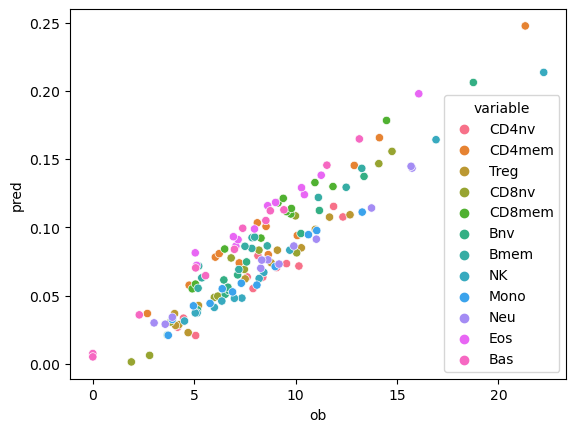

In [340]:
sns.scatterplot(data=pl,x='ob',y='pred',hue='variable')

In [382]:
%%time
df=pd.read_pickle(data_path+'mgb/dna.pkl')
df.shape

CPU times: user 96 ms, sys: 4.28 s, total: 4.37 s
Wall time: 12.7 s


(825095, 461)

In [383]:
dec = gallery.get("TwelveCellDeconvoluteBloodEPIC")

In [392]:
art2.dnam=df

In [394]:
pred=dec.predict(art2)

In [398]:
meta=pd.read_csv(data_path+'mgb/meta.csv',index_col=0)

In [406]:
pl=meta.join(pred.T).drop(['sex','race'],axis=1)
pl.corr()

,plate,age_at_sample,dead,years_until_death,Bas,Bmem,Bnv,CD4mem,CD4nv,CD8mem,CD8nv,Eos,Mono,NK,Neu,Treg
plate,1.000000,-0.026642,0.021707,-0.208154,-0.029999,0.032109,0.037655,-0.025950,-0.005130,-0.004257,0.011967,-0.018448,0.041491,-0.073871,0.010409,-0.048369
age_at_sample,-0.026642,1.000000,0.368178,-0.092349,0.070323,-0.038432,-0.123961,0.193372,-0.177211,0.074971,-0.681621,0.057173,0.227632,0.254280,0.072809,-0.084063
dead,0.021707,0.368178,1.000000,-0.541358,0.044187,-0.042985,-0.111228,-0.107828,-0.142631,-0.035973,-0.246501,0.016753,0.170316,0.061314,0.139394,-0.043160
years_until_death,-0.208154,-0.092349,-0.541358,1.000000,0.034091,0.041295,0.136588,0.145084,0.039800,0.156253,0.068043,0.018282,-0.046959,0.065584,-0.171735,-0.005512
Bas,-0.029999,0.070323,0.044187,0.034091,1.000000,0.120295,0.065395,0.247980,-0.011734,0.159791,0.016376,0.101059,0.146996,0.175618,-0.336277,0.054206
Bmem,0.032109,-0.038432,-0.042985,0.041295,0.120295,1.000000,0.001908,0.302413,-0.030572,0.178701,0.065821,0.017663,-0.057548,0.093607,-0.268230,-0.024123
Bnv,0.037655,-0.123961,-0.111228,0.136588,0.065395,0.001908,1.000000,0.265796,0.150295,0.096183,0.211536,-0.027656,0.009647,0.022260,-0.498470,0.121626
CD4mem,-0.025950,0.193372,-0.107828,0.145084,0.247980,0.302413,0.265796,1.000000,0.017347,0.317182,-0.095149,0.049314,0.164254,0.262919,-0.659923,-0.056114
CD4nv,-0.005130,-0.177211,-0.142631,0.039800,-0.011734,-0.030572,0.150295,0.017347,1.000000,-0.142346,0.279067,-0.001681,-0.108266,-0.030554,-0.446333,-0.055763
CD8mem,-0.004257,0.074971,-0.035973,0.156253,0.159791,0.178701,0.096183,0.317182,-0.142346,1.000000,-0.120866,-0.011664,0.036776,0.277404,-0.412649,-0.009736


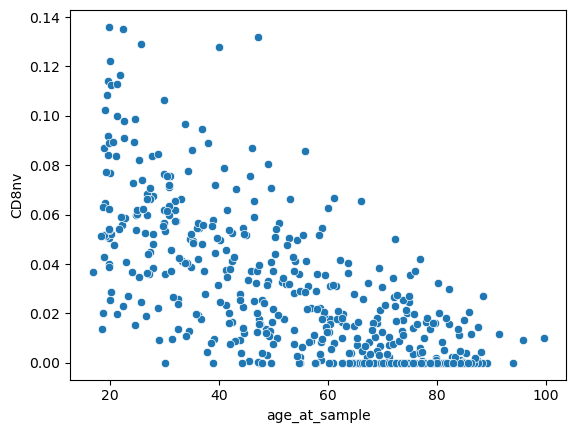

In [419]:
ax=sns.scatterplot(data=pl,x='age_at_sample',y='CD8nv')
#ax.set(yscale="log",ylim=[0.0001,1])

In [357]:
#art mix
t = pd.read_table(data_path+'comp/GSE180683_Matrix_processed.txt',index_col=0,nrows=10**2,usecols=[0]+list(range(1,152,2)))

In [372]:
t_meta=pd.read_table('https://ftp.ncbi.nlm.nih.gov/geo/series/GSE180nnn/GSE180683/matrix/GSE180683_series_matrix.txt.gz',skiprows=39,index_col=0)

In [360]:
art2=art.copy()

In [361]:
art2.dnam=t